In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from pymer4.models import Lmer,Lm
from matplotlib import cm
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
pd.set_option('display.max_columns', None)

In [3]:
concatenated_df = pd.read_pickle('./concatenated_df_oct.pkl')
age = pd.read_pickle('./age_oct.pkl')


average age: 30.741868131868134
average age controls: 35.067391304347844
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


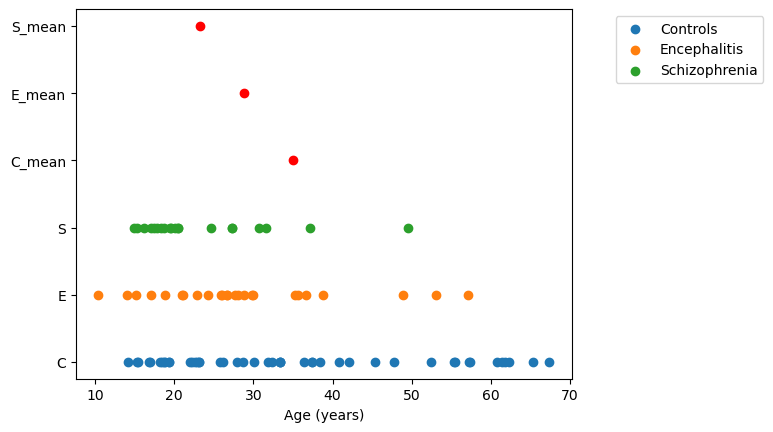

In [4]:
age['Group'] = age['Subject'].str[0]
age.tail(9)


# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
  
plt.errorbar(np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), "C_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']), "E_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']), "S_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')

plt.xlabel('Age (years)')
plt.savefig('Age variance', bbox_inches='tight')
plt.show()




In [5]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
#data = concatenated_df[crs1]
data=concatenated_df

# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')


# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F8', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
#chan_f = ['Fz','F3','F4']
chan_f = ['Fz','F3','F4','F7','F8']
data_fp['Position'] = 'P'
data_fp.loc[data_fp.Channel.isin(chan_f),'Position'] = 'F'
data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)


/tmp/ipykernel_4092670/3263902381.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'P'


## AGE COMPRISON between 20- and 20+

In [6]:
data_F = data_fp.copy()
data_F = data_F[data_F['Position'] == 'F'].reset_index(drop=True)
data_F.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
0  16147  0.390689  1406.81      1407.16  1407.77  1408.12      1.64   
1  11458  0.391044  1408.03      1408.31  1408.67  1409.26      1.50   
2  14355  0.393181  1415.75      1416.35  1416.68  1416.93      1.48   
3  11459  0.393536  1417.03      1417.28  1417.47  1417.69      0.96   
4  14356  0.397639  1431.74      1431.96  1432.18  1432.82      1.32   

   ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
0  -54.438037   56.538966  110.977003  317.077151   0.609756      2      F4   
1  -59.791872   41.681846  101.473718  362.406135   0.666667      2      F7   
2  -43.574775   38.377907   81.952683  136.587804   0.675676      2      Fz   
3  -82.223783   45.544797  127.768579  511.074318   1.041667      2      F7   
4  -42.860329   34.949432   77.809761  353.680731   0.757576      2      Fz   

   IdxChannel Group Subject Session    Age Machine ConfArousal Position  
0           9     C     C02       1  22.91       O           0        F  
1           6     C     C02       1  22.91       O           0        F  
2           8     C     C02       1  22.91       O           0        F  
3           6     C     C02       1  22.91       O           0        F  
4           8     C     C02       1  22.91       O           0        F

In [7]:
data_F[data_F['Stage'] == 3]['Start']

47        0.673000
48        0.679381
49        0.679381
50        0.679381
51        0.679381
            ...   
843546    5.718425
843547    5.722625
843548    5.722628
843549    5.722950
843737    6.576497
Name: Start, Length: 559209, dtype: float64

In [8]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)
data_F['time_n'] = data_F['Start']
time_threshold = 0.005
slope_threshold = 0.20

def filter_group(group):
    tree = cKDTree(group[['time_n', 'Slope']])
    pairs = tree.query_pairs(r=np.sqrt(time_threshold**2 + slope_threshold**2))
    keep = np.ones(len(group), dtype=bool)
    for i, j in pairs:
        keep[j] = False
    return group[keep]

data_F = data_F.groupby('Id', group_keys=False).apply(filter_group).drop(columns=['time_n']).reset_index(drop=True)


In [9]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

def find_next_bigger(sorted_array, value1):
    for num in sorted_array:
        if num > value1:
            return num
    
    return None

def first_block_all(data, data_n3, bin_size, threshold_sum,id):
    if len(data_n3) < threshold_sum:
         return None

    hist_values, bin_edges = np.histogram(data, bins=np.arange(0, round(max(data),2) + bin_size, bin_size))
    hist_valuesn3, bin_edgesn3 = np.histogram(data_n3, bins=np.arange(0, round(max(data_n3),2) + bin_size, bin_size))

    nz_indices = np.where(hist_values > 10)[0]
    nz_indices3 = np.where(hist_valuesn3 > 5)[0]

    nz_edges = np.round(bin_edges[nz_indices],2)
    nz_edges3 = np.round(bin_edgesn3[nz_indices3],2)

    cbins = [nz_edges3[0]]
    if id == 'C07_1':
        print(nz_edges)

    if nz_edges[0] > cbins[0]:
        nz_edges = np.concatenate(([cbins[0]], nz_edges))

    for i in range(1, len(nz_edges)): 
        if nz_edges[i] in nz_edges3 or nz_edges[i] > cbins[0]:
            if round(nz_edges[i] - nz_edges[i - 1],2) == bin_size:
                if id == 'C07_1':
                 print(nz_edges[i])
                cbins.append(nz_edges[i])
            else:
                if (sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum):
                    if id == 'C07_1':
                        print(cbins)
                        print(sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]))
                    return cbins[0]

                if nz_edges[i] in nz_edges3:
                    cbins = [nz_edges[i]]
                else:
                    if find_next_bigger(nz_edges3, nz_edges[i]) is not None:
                        cbins = [find_next_bigger(nz_edges3, nz_edges[i])]
                    else:
                        return None

    if sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum:
                if id == 'C07_1':
                        print(cbins)
                        print(sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]))
                return cbins[0]
    return None



data_starts = data_F.groupby('Id').apply(
    lambda x: first_block_all(
        data=x['Start'],
        data_n3=x[x['Stage'] == 3]['Start'],
        bin_size=0.05,
        threshold_sum=350,
        id = x['Id'].values[0]
    )
).reset_index(name='Start_Block')




[0.85 0.9  0.95 1.   1.05 1.1  1.2  1.25 1.45 2.25 2.3  2.4  2.45 2.5
 2.55 2.65 3.55 3.95 4.75 4.8  4.85 6.25 6.3  6.35 6.4  6.45 6.5  6.55
 6.6 ]
0.9
0.95
1.0
1.05
1.1
2.3
2.45
2.5
2.55
4.8
4.85
6.3
6.35
6.4
6.45
6.5
6.55
6.6


In [10]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

def find_next_bigger(sorted_array, value1):
    for num in sorted_array:
        if num > value1:
            return num
    
    return None

def first_block_all(data, data_n3, bin_size, threshold_sum,id):
    if len(data_n3) < threshold_sum:
         return None

    hist_values, bin_edges = np.histogram(data, bins=np.arange(0, round(max(data),2) + bin_size, bin_size))
    hist_valuesn3, bin_edgesn3 = np.histogram(data_n3, bins=np.arange(0, round(max(data_n3),2) + bin_size, bin_size))

    nz_indices = np.where(hist_values > 10)[0]
    nz_indices3 = np.where(hist_valuesn3 > 5)[0]

    nz_edges = np.round(bin_edges[nz_indices],2)
    nz_edges3 = np.round(bin_edgesn3[nz_indices3],2)

    cbins = [nz_edges3[0]]
    if id == 'C07_1':
        print(nz_edges)

    if nz_edges[0] > cbins[0]:
        nz_edges = np.concatenate(([cbins[0]], nz_edges))

    for i in range(1, len(nz_edges)): 
        if nz_edges[i] in nz_edges3 or nz_edges[i] > cbins[0]:
            if round(nz_edges[i] - nz_edges[i - 1],2) == bin_size:
                if id == 'C07_1':
                 print(nz_edges[i])
                cbins.append(nz_edges[i])
            else:
                if (sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum):
                    if id == 'C07_1':
                        print(cbins)
                        print(sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]))
                    return cbins[0]

                if nz_edges[i] in nz_edges3:
                    cbins = [nz_edges[i]]
                else:
                    if find_next_bigger(nz_edges3, nz_edges[i]) is not None:
                        cbins = [find_next_bigger(nz_edges3, nz_edges[i])]
                    else:
                        return None

    if sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum:
                if id == 'C07_1':
                        print(cbins)
                        print(sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]))
                return cbins[0]
    return None



data_starts = data_F.groupby('Id').apply(
    lambda x: first_block_all(
        data=x['Start'],
        data_n3=x[x['Stage'] == 3]['Start'],
        bin_size=0.05,
        threshold_sum=400,
        id = x['Id'].values[0]
    )
).reset_index(name='Start_Block')





[0.85 0.9  0.95 1.   1.05 1.1  1.2  1.25 1.45 2.25 2.3  2.4  2.45 2.5
 2.55 2.65 3.55 3.95 4.75 4.8  4.85 6.25 6.3  6.35 6.4  6.45 6.5  6.55
 6.6 ]
0.9
0.95
1.0
1.05
1.1
2.3
2.45
2.5
2.55
4.8
4.85
6.3
6.35
6.4
6.45
6.5
6.55
6.6


In [11]:
data_F['N23_times'] = data_F['Id'].map(data_starts.set_index('Id')['Start_Block'])
data_F['time_rel'] = data_F['Start'] - data_F['N23_times']
data_F = data_F[data_F['time_rel'] >= 0]

data_F['N3_times'] = data_F['Start'].where(data_F['Stage'] == 3)
N3_start_time = data_F.groupby(['Subject','Session'])['N3_times'].transform('min')
data_F['N3_times'] = N3_start_time
data_F['time_rel'] = data_F['Start'] - data_F['N3_times']

data_F['diff'] = data_F['N3_times'] - data_F['N23_times']

data_allF = data_F[(data_F['time_rel'] <= 0.5) & (data_F['time_rel'] >= 0)]
#data_allF = data_allF[(data_allF['Stage'] == 3) | (data_allF['time_rel'] >= 0.2)]

data_allF = data_allF.dropna(subset=['Age'])

data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

data_F['condBlock'] = 0
for index, row in data_F.iterrows():
    if row['Stage'] == 3:
        t0 = row['Start']
        t0_5 = t0 + 0.5
        id = row['Id']
        data_Id = data_F.where(data_F['Id'] == id)
        data_Id['N3'] = data_Id['Stage'].apply(lambda x: 1 if x == 3 else 0)
        c = data_Id[(data_Id['Start'] > t0) & (data_Id['Start'] <= t0_5)] 
        c = c['N3'].eq(1).sum()
        if c >= 100:
            row['condBlock'] = 1

In [12]:
result_df = data_allF.groupby('Id')['diff'].first().reset_index()
result_df[0:60]



Id      diff
0   C02_1  0.011431
1   C03_1  0.024964
2   C03_4  0.036644
3   C04_1  0.004475
4   C05_4  0.005172
5   C06_1  0.003678
6   C06_4  0.008653
7   C07_4  0.043039
8   C08_1  0.036106
9   C08_4  0.017881
10  C09_4  0.005958
11  C10_1  0.019253
12  C10_4  0.018286
13  C11_1  0.019064
14  C12_1  0.011703
15  C13_1  0.000669
16  C13_4  0.026403
17  C14_1  0.002992
18  C14_4  0.000692
19  C15_1  0.034231
20  C15_4  0.009036
21  C16_1  0.042142
22  C16_4  0.017597
23  C17_1  0.040100
24  C18_1  0.027861
25  C20_1  0.008125
26  C20_4  0.016769
27  C21_1  0.001456
28  C22_1  0.008797
29  C23_1  0.002664
30  C23_4  0.025117
31  C24_1  0.009689
32  C28_1  0.041889
33  C28_4  0.011081
34  C29_1  0.043942
35  C29_4  0.033803
36  C30_1  0.009069
37  C32_4  0.042069
38  C34_1  0.028506
39  C36_1  0.011111
40  C38_1  0.009478
41  C44_1  0.003889
42  C45_1  0.005403
43  C47_1  0.000075
44  E01_2  0.000089
45  E01_3  0.002592
46  E02_1  0.033803
47  E02_2  0.005336
48  E02_3  0.025567
49  E02_4  0.017108
50  E03_1  0.038875
51  E03_2  0.034158
52  E03_3  0.006522
53  E03_4  0.033494
54  E04_1  0.008714
55  E04_2  0.002717
56  E04_3  0.006467
57  E04_4  0.004489
58  E05_1  0.025111
59  E05_2  0.002603

In [13]:
result_df = data_allF.groupby('Id')['N3_times'].first().reset_index()
result_df[0:60]


Id  N3_times
0   C02_1  0.711431
1   C03_1  2.324964
2   C03_4  3.386644
3   C04_1  0.254475
4   C05_4  1.005172
5   C06_1  0.353678
6   C06_4  0.858653
7   C07_4  1.243039
8   C08_1  1.836106
9   C08_4  0.517881
10  C09_4  2.605958
11  C10_1  0.369253
12  C10_4  0.418286
13  C11_1  0.519064
14  C12_1  0.361703
15  C13_1  0.800669
16  C13_4  1.176403
17  C14_1  0.502992
18  C14_4  1.350692
19  C15_1  0.934231
20  C15_4  0.509036
21  C16_1  1.692142
22  C16_4  1.017597
23  C17_1  0.290100
24  C18_1  0.777861
25  C20_1  1.208125
26  C20_4  1.416769
27  C21_1  1.751456
28  C22_1  0.608797
29  C23_1  0.902664
30  C23_4  0.675117
31  C24_1  0.959689
32  C28_1  1.191889
33  C28_4  0.511081
34  C29_1  0.743942
35  C29_4  0.483803
36  C30_1  0.509069
37  C32_4  0.942069
38  C34_1  2.178506
39  C36_1  0.511111
40  C38_1  0.359478
41  C44_1  1.303889
42  C45_1  0.855403
43  C47_1  0.300075
44  E01_2  0.550089
45  E01_3  0.802592
46  E02_1  0.333803
47  E02_2  0.355336
48  E02_3  0.375567
49  E02_4  0.367108
50  E03_1  0.438875
51  E03_2  0.484158
52  E03_3  0.156522
53  E03_4  0.433494
54  E04_1  0.608714
55  E04_2  0.452717
56  E04_3  0.356467
57  E04_4  0.354489
58  E05_1  3.275111
59  E05_2  1.852603

In [14]:
data_allF[data_allF['Id'] == 'C02_1'].head(9)

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
53  14366  0.711431  2561.41      2561.65  2561.89  2562.17      1.02   
54  16157  0.711439  2561.44      2561.67  2561.92  2562.21      1.03   
55  11472  0.718289  2586.16      2586.47  2586.69  2587.44      1.60   
56  12771  0.718289  2586.20      2586.51  2586.74  2587.45      1.61   
57  16158  0.718289  2586.21      2586.55  2586.80  2587.41      1.57   
58  17692  0.718289  2586.19      2586.53  2586.87  2587.36      1.52   
59  16159  0.722950  2602.98      2603.20  2603.48  2603.80      1.18   
60  14367  0.728472  2622.79      2623.03  2623.25  2623.97      1.47   
61  16160  0.730631  2630.59      2630.83  2631.04  2631.30      1.03   

    ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
53  -43.055807   39.801527   82.857334  345.238892   0.980392      3      Fz   
54  -41.747439   44.001763   85.749202  372.822617   0.970874      3      F4   
55  -67.717177   20.232169   87.949346  283.707569   0.625000      3      F7   
56 -103.667240   46.635767  150.303006  484.848408   0.621118      3      F3   
57  -91.779559   43.404657  135.184215  397.600633   0.636943      3      F4   
58  -49.231720   26.332969   75.564689  222.249086   0.657895      3      F8   
59  -62.086992   91.715645  153.802637  699.102896   0.847458      3      F4   
60  -45.009583   36.084354   81.093936  337.891401   0.680272      3      Fz   
61  -90.122824   65.240226  155.363050  647.346042   0.970874      3      F4   

    IdxChannel Group Subject Session    Age Machine ConfArousal Position  \
53           8     C     C02       1  22.91       O           0        F   
54           9     C     C02       1  22.91       O           0        F   
55           6     C     C02       1  22.91       O           0        F   
56           7     C     C02       1  22.91       O           0        F   
57           9     C     C02       1  22.91       O           0        F   
58          10     C     C02       1  22.91       O           0        F   
59           9     C     C02       1  22.91       O           0        F   
60           8     C     C02       1  22.91       O           0        F   
61           9     C     C02       1  22.91       O           0        F   

       Id  N23_times  time_rel  N3_times      diff  
53  C02_1        0.7  0.000000  0.711431  0.011431  
54  C02_1        0.7  0.000008  0.711431  0.011431  
55  C02_1        0.7  0.006858  0.711431  0.011431  
56  C02_1        0.7  0.006858  0.711431  0.011431  
57  C02_1        0.7  0.006858  0.711431  0.011431  
58  C02_1        0.7  0.006858  0.711431  0.011431  
59  C02_1        0.7  0.011519  0.711431  0.011431  
60  C02_1        0.7  0.017042  0.711431  0.011431  
61  C02_1        0.7  0.019200  0.711431  0.011431

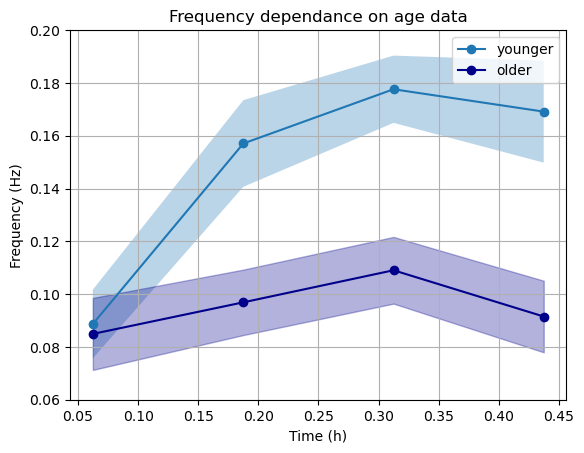

In [15]:
nbins = 4

bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Group']=='C']
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=nbins)  # Adjust the number of bins as needed
diff_time =  0.5/nbins

bins_data_F = bins_data_F[bins_data_F['Id']!='C21_1']
binsy_data_F = bins_data_F[bins_data_F['Age']<20]
binso_data_F = bins_data_F[bins_data_F['Age']>35]

#younger
binsy_data_F = binsy_data_F.groupby(['Id', 'time_rel']).size().reset_index(name='Num')
binsy_data_F['Freq'] = (binsy_data_F['Num'] / diff_time)/(3600*5)
meany_data_F = binsy_data_F.groupby(['time_rel'])['Freq'].agg(['mean', 'sem']).reset_index()


# Plot the individual curves for each name
meany_data_F["time_rel_c"] = meany_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = meany_data_F['time_rel_c'].unique()

#older
binso_data_F = binso_data_F.groupby(['Id','time_rel']).size().reset_index(name='Num')
binso_data_F['Freq'] = (binso_data_F['Num'] / diff_time)/(3600*5)
meano_data_F = binso_data_F.groupby(['time_rel'])['Freq'].agg(['mean', 'sem']).reset_index()


# Plot the individual curves for each name
meano_data_F["time_rel_c"] = meano_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = meano_data_F['time_rel_c'].unique()


#ALL
plt.title('Frequency dependance on age data')
plt.plot(time_intervals, meany_data_F['mean'], marker='o', label='younger')
plt.fill_between(time_intervals, meany_data_F['mean'] - meany_data_F['sem'],
                    meany_data_F['mean'] + meany_data_F['sem'], alpha=0.3)
plt.plot(time_intervals, meano_data_F['mean'], marker='o', color='darkblue',label='older')
plt.fill_between(time_intervals, meano_data_F['mean'] - meano_data_F['sem'],
                    meano_data_F['mean'] + meano_data_F['sem'], color='darkblue', alpha=0.3)
plt.xlabel('Time (h)')
plt.ylim([0.06,0.2])
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.savefig('Age_freq.png')
plt.grid(True)
plt.show()


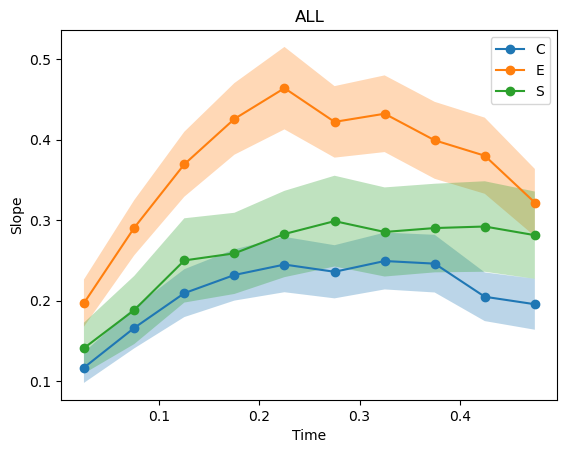

In [16]:

nbins = 10

bins_data_F = data_allF.copy()
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=nbins)  # Adjust the number of bins as needed
diff_time =  0.5/nbins

#all
bins_data_F = bins_data_F.groupby(['Session', 'Subject', 'time_rel']).size().reset_index(name='Num')
bins_data_F['Freq'] = (bins_data_F['Num'] / diff_time)/(3600)
bins_data_F['Group'] = bins_data_F['Subject'].str[0]
mean_data_F = bins_data_F.groupby(['Group','time_rel'])['Freq'].agg(['mean', 'sem']).reset_index()

# Plot the individual curves for each name
mean_data_F["time_rel_c"] = mean_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = mean_data_F['time_rel_c'].unique()

#ALL
plt.title('ALL')
for name, group in mean_data_F.groupby('Group'):
    plt.plot(time_intervals, group['mean'], marker='o', label=name)
    plt.fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Slope')
plt.legend()
plt.show()



# Freq modelling for controls

In [17]:
# Obtain first hour of SWS:

#BINS DATA FRAME _ CONTROLS

nbins = 6

bdf_c = data_allF.copy()
bdf_c = bdf_c[bdf_c['Group']=='C']
bdf_c = bdf_c[bdf_c['Age']<30]
bdf_c['time_rel'] = pd.cut(bdf_c['time_rel'], bins=nbins)  # Adjust the number of bins as needed
diff_time =  0.5/nbins

#all
bdf_c = bdf_c.groupby(['Session', 'Subject', 'time_rel']).size().reset_index(name='Num')
bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
bdf_c['Freq'] = (bdf_c['Num'] / (diff_time*3600*5))
bdf_c['Group'] = bins_data_F['Subject'].str[0]
bdf_c['Group'] = bdf_c['Subject'].str[0]

print(bdf_c[bdf_c['Id']=='C15_4'])


age_c = age[age['Group']=='C']
bdf_c = bdf_c.merge(age_c)
bdf_c = bdf_c[bdf_c['Age']<20]




     Session Subject           time_rel  Num     Id      Freq Group
186        4     C15  (-0.0005, 0.0833]  229  C15_4  0.152667     C
187        4     C15    (0.0833, 0.167]  258  C15_4  0.172000     C
188        4     C15      (0.167, 0.25]  297  C15_4  0.198000     C
189        4     C15      (0.25, 0.333]  248  C15_4  0.165333     C
190        4     C15     (0.333, 0.417]  169  C15_4  0.112667     C
191        4     C15       (0.417, 0.5]   60  C15_4  0.040000     C


In [18]:

(data_allF[data_allF['Id']=='C15_4'])


Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
93256  11979  0.509036  1832.81      1833.09  1833.42  1833.79      1.26   
93257  10025  0.510017  1836.34      1836.56  1836.77  1837.01      0.95   
93258  14436  0.513675  1849.59      1849.89  1850.14  1850.39      1.16   
93259  11981  0.513722  1849.71      1849.97  1850.17  1850.37      0.97   
93260  10026  0.513725  1849.74      1849.99  1850.20  1850.40      0.99   
...      ...       ...      ...          ...      ...      ...       ...   
94512  10493  1.005514  3620.15      3620.47  3620.61  3620.81      0.96   
94513   9289  1.005528  3620.20      3620.48  3620.68  3620.97      1.07   
94514  10494  1.007017  3625.59      3625.86  3626.07  3626.75      1.49   
94515  16515  1.007033  3625.61      3625.89  3626.06  3626.71      1.39   
94516  10495  1.007431  3626.96      3627.16  3627.37  3627.60      0.85   

       ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
93256  -44.921035   44.943759   89.864794  320.945693   0.793651      3   
93257  -57.069529   52.960618  110.030147  500.137032   1.052632      3   
93258  -46.121373   30.167063   76.288435  254.294785   0.862069      3   
93259  -64.597845   40.507130  105.104975  404.249904   1.030928      3   
93260  -59.976968   43.999830  103.976799  415.907195   1.010101      3   
...           ...         ...         ...         ...        ...    ...   
94512  -96.896963   21.175055  118.072019  368.975058   1.041667      2   
94513  -72.993821   34.912592  107.906412  385.380044   0.934579      2   
94514 -112.711646   62.333440  175.045085  648.315130   0.671141      2   
94515  -58.379327   20.895670   79.274997  283.124988   0.719424      2   
94516  -53.129159   49.573998  102.703158  513.515788   1.176471      2   

      Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
93256      Fz           8     C     C15       4  19.28       N           0   
93257      F3           7     C     C15       4  19.28       N           0   
93258      F4           9     C     C15       4  19.28       N           0   
93259      Fz           8     C     C15       4  19.28       N           0   
93260      F3           7     C     C15       4  19.28       N           0   
...       ...         ...   ...     ...     ...    ...     ...         ...   
94512      F3           7     C     C15       4  19.28       N           0   
94513      F7           6     C     C15       4  19.28       N           0   
94514      F3           7     C     C15       4  19.28       N           0   
94515      F8          10     C     C15       4  19.28       N           0   
94516      F3           7     C     C15       4  19.28       N           0   

      Position     Id  N23_times  time_rel  N3_times      diff  
93256        F  C15_4        0.5  0.000000  0.509036  0.009036  
93257        F  C15_4        0.5  0.000981  0.509036  0.009036  
93258        F  C15_4        0.5  0.004639  0.509036  0.009036  
93259        F  C15_4        0.5  0.004686  0.509036  0.009036  
93260        F  C15_4        0.5  0.004689  0.509036  0.009036  
...        ...    ...        ...       ...       ...       ...  
94512        F  C15_4        0.5  0.496478  0.509036  0.009036  
94513        F  C15_4        0.5  0.496492  0.509036  0.009036  
94514        F  C15_4        0.5  0.497981  0.509036  0.009036  
94515        F  C15_4        0.5  0.497997  0.509036  0.009036  
94516        F  C15_4        0.5  0.498394  0.509036  0.009036  

[1261 rows x 27 columns]

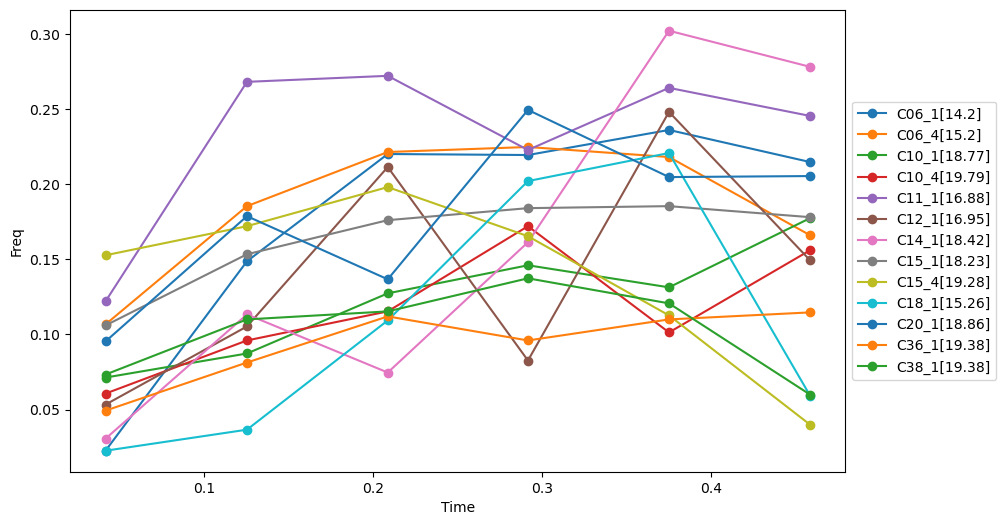

In [19]:

plt.figure(figsize=(10, 6))

# Plot the individual curves for each age

bdf_c["time_rel_c"] = bdf_c["time_rel"].apply(lambda x: x.mid).astype('object')
bdf_fc = bdf_c.groupby(['Id',"time_rel_c"])[['Freq','Age']].first().reset_index()

bdf_c = bdf_c[bdf_c['Id']!='C32_1']

time_intervals = bdf_fc['time_rel_c'].unique()
for name, Id in bdf_fc.groupby('Id'):
    y = Id['Freq'].values
    y_padded = np.append(y, [np.nan] * (len(time_intervals) - len(y)))
    plt.plot(time_intervals, y_padded, marker='o', label=str(name) + str(Id['Age'].unique()))

plt.xlabel('Time')
plt.ylabel('Freq')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [20]:
bdf_c

Session Subject           time_rel  Num     Id      Freq Group  \
12         1     C06  (-0.0005, 0.0833]   34  C06_1  0.022667     C   
13         1     C06    (0.0833, 0.167]  223  C06_1  0.148667     C   
14         1     C06      (0.167, 0.25]  330  C06_1  0.220000     C   
15         1     C06      (0.25, 0.333]  329  C06_1  0.219333     C   
16         1     C06     (0.333, 0.417]  354  C06_1  0.236000     C   
..       ...     ...                ...  ...    ...       ...   ...   
163        4     C15    (0.0833, 0.167]  258  C15_4  0.172000     C   
164        4     C15      (0.167, 0.25]  297  C15_4  0.198000     C   
165        4     C15      (0.25, 0.333]  248  C15_4  0.165333     C   
166        4     C15     (0.333, 0.417]  169  C15_4  0.112667     C   
167        4     C15       (0.417, 0.5]   60  C15_4  0.040000     C   

               Birthdate             Testdate  M/F    Age time_rel_c  
12   2003-04-10 00:00:00  2017-06-22 00:00:00    F  14.20     0.0414  
13   2003-04-10 00:00:00  2017-06-22 00:00:00    F  14.20    0.12515  
14   2003-04-10 00:00:00  2017-06-22 00:00:00    F  14.20     0.2085  
15   2003-04-10 00:00:00  2017-06-22 00:00:00    F  14.20     0.2915  
16   2003-04-10 00:00:00  2017-06-22 00:00:00    F  14.20      0.375  
..                   ...                  ...  ...    ...        ...  
163  1999-11-25 00:00:00  2019-03-07 00:00:00  NaN  19.28    0.12515  
164  1999-11-25 00:00:00  2019-03-07 00:00:00  NaN  19.28     0.2085  
165  1999-11-25 00:00:00  2019-03-07 00:00:00  NaN  19.28     0.2915  
166  1999-11-25 00:00:00  2019-03-07 00:00:00  NaN  19.28      0.375  
167  1999-11-25 00:00:00  2019-03-07 00:00:00  NaN  19.28     0.4585  

[78 rows x 12 columns]

    Session Subject           time_rel  Num     Id      Freq Group  \
12        1     C06  (-0.0005, 0.0833]   34  C06_1  0.022667     C   
13        1     C06    (0.0833, 0.167]  223  C06_1  0.148667     C   
14        1     C06      (0.167, 0.25]  330  C06_1  0.220000     C   
15        1     C06      (0.25, 0.333]  329  C06_1  0.219333     C   
16        1     C06     (0.333, 0.417]  354  C06_1  0.236000     C   

              Birthdate             Testdate M/F   Age time_rel_c age_group  
12  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2     0.0414     10-17  
13  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2    0.12515     10-17  
14  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2     0.2085     10-17  
15  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2     0.2915     10-17  
16  2003-04-10 00:00:00  2017-06-22 00:00:00   F  14.2      0.375     10-17  
    Session Subject           time_rel  Num     Id      Freq Group  \
12        1     C06  (-0.0005, 0.0833]   

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

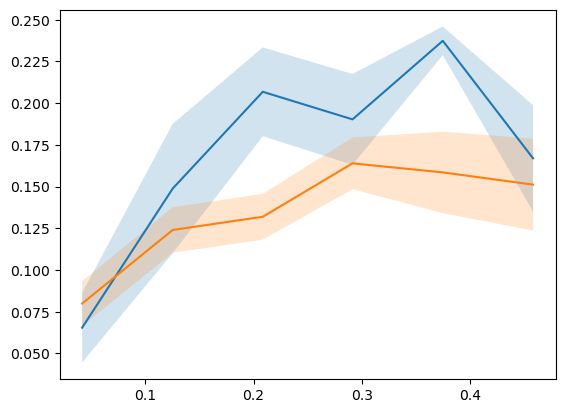

In [21]:
bins = [10, 18, 22, 32, 42, np.inf]
labels = ['10-17','18-21', '22-31','32-41', '42+']
bdf_c['age_group'] = pd.cut(bdf_c['Age'], bins=bins, labels=labels, right=False)

for age_group, group_data in bdf_c.groupby('age_group'):
    print(group_data.head())
    mean_score = group_data.groupby('time_rel_c')['Freq'].mean()
    print(group_data.head())
    sem_score = group_data.groupby('time_rel_c')['Freq'].sem()
    plt.plot(time_intervals, mean_score.values, label=f'Age Group: {age_group}')
    plt.fill_between(mean_score.index, mean_score - sem_score, mean_score + sem_score, alpha=0.2)

    print(sem_score)
plt.xlabel('Time (h)',fontsize=12)
plt.ylabel('Freq(Hz)',fontsize=12)
plt.title('Mean frequency by age group', fontsize=18)
plt.ylim((0,0.4))
plt.legend()
plt.tight_layout()
plt.savefig('Age_dist')
plt.show()

 _____________ Fitted Parameters Fo:
M: 0.21012431764469286
N: -0.006815392761667542
 _____________ Fitted Parameters Ft:
a: -7.6978119626721195
b: -7.934024349891384
c: 991.9971135235608
[[ 1.96668502e+09  1.96638615e+09 -2.50224058e+11]
 [ 1.96638615e+09  1.96608732e+09 -2.50186029e+11]
 [-2.50224058e+11 -2.50186029e+11  3.18363751e+13]]


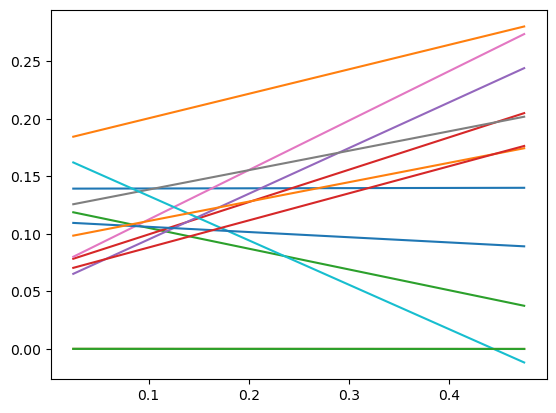

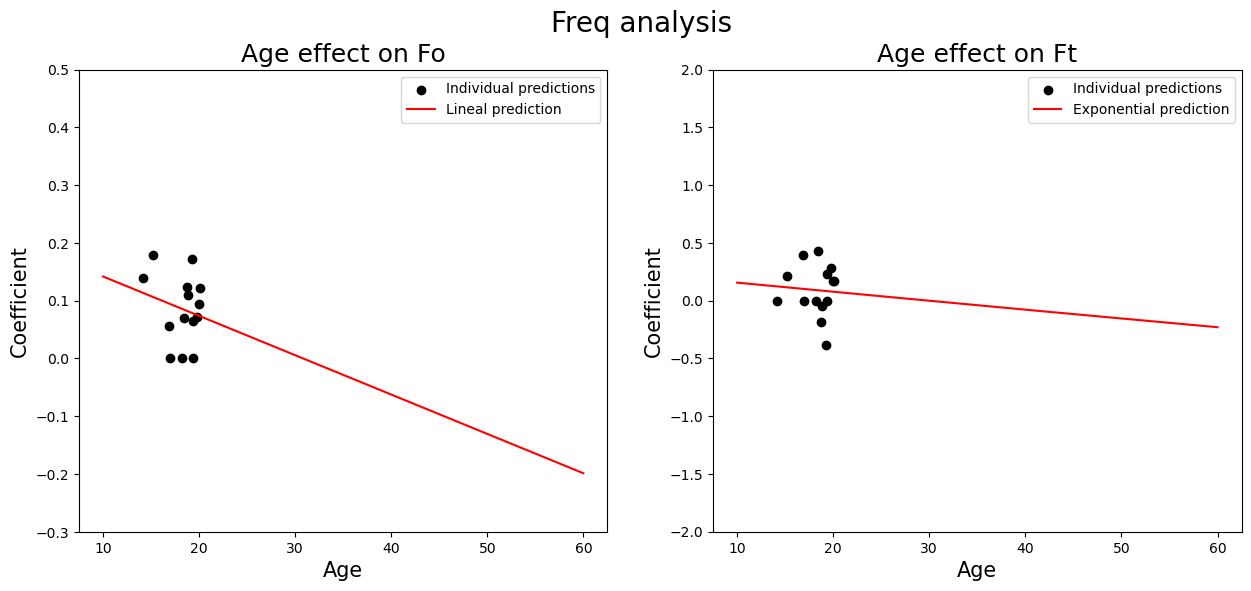

In [ ]:
#LOG BINS



bdf_fc['sAge'] = bdf_fc['Age']/50


def func_l(x, m, n):
    return m + n*x

def func_exp(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
m_list = []
n_list = []


for name, Subject in bdf_fc.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    try:
        y = Subject.Freq.values
        time_intervals = Subject['time_rel_c'].unique()
        x = time_intervals
        
        popt, pcov = curve_fit(func_l, x, y,bounds=([0,-1000],[1000,1000]))

        plt.plot(x, func_l(x,popt[0],popt[1]))
        coef_m = popt[0]
        coef_n = popt[1]

        x_list.append(Subject['Age'].unique()[0])
        m_list.append(coef_m)
        n_list.append(coef_n)
    except:
        print('-1')

fig, ax = plt.subplots(1, 2, figsize = (15, 6))

splot = 0
coef_names = ['Fo','Ft']
total_coefs = []

for coef_list in [m_list,n_list]:
    y_list = coef_list

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)

    if splot == 0:
        
        popt_t, pcov_t = curve_fit(func_l, x_sorted, y_sorted,bounds=([0,-1000],[1000,1000]))

        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("M:", popt_t[0])
        print("N:", popt_t[1])

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])


        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_l(x_ages, popt_t[0], popt_t[1]), c='red', label='Lineal prediction')

    else: 
        popt_t, pcov_t,info, mesg,ier= curve_fit(func_exp, x_sorted, y_sorted, bounds=([-10000, -15000, 0], [10000, 0, 1000]), full_output=True)


        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("a:", popt_t[0])
        print("b:", popt_t[1])
        print("c:", popt_t[2])
        print(pcov_t)

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])
        total_coefs.append(popt_t[2])
    

        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_exp(x_ages, popt_t[0], popt_t[1], popt_t[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot],fontsize=18)
    ax[splot].set_xlabel('Age',fontsize=15)
    ax[splot].set_ylabel('Coefficient',fontsize=15)


    if splot == 0:
        ax[splot].set_ylim([-0.3,0.5])
    else:
        ax[splot].set_ylim([-2,2])

    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Freq analysis", fontsize=20)
plt.savefig('Age model', bbox_inches='tight')
plt.show()



In [ ]:
popt


array([0.06463693, 0.23525357])

In [ ]:
age

Subject  Session            Birthdate             Testdate  M/F    Age  \
0       C02        1  1994-05-28 00:00:00  2017-04-26 00:00:00    F  22.91   
1       C03        1  1988-09-09 00:00:00  2017-05-18 00:00:00    F  28.69   
2       C04        1  1987-05-24 00:00:00  2017-06-08 00:00:00    F  30.04   
3       C06        1  2003-04-10 00:00:00  2017-06-22 00:00:00    F  14.20   
4       C07        1  1994-06-05 00:00:00  2017-07-05 00:00:00    F  23.08   
..      ...      ...                  ...                  ...  ...    ...   
160     S07        4  2002-06-21 00:00:00  2019-03-28 00:00:00  NaN  16.77   
161     S08        4  2003-05-09 00:00:00  2019-03-27 00:00:00  NaN  15.88   
162     S11        4  2003-05-15 00:00:00  2019-11-07 00:00:00  NaN  16.48   
163     S12        4  1998-03-04 00:00:00  2019-09-05 00:00:00  NaN  21.51   
164     S15        4  2000-06-18 00:00:00  2020-02-20 00:00:00  NaN  19.67   

    Group  
0       C  
1       C  
2       C  
3       C  
4       C  
..    ...  
160     S  
161     S  
162     S  
163     S  
164     S  

[165 rows x 7 columns]

In [ ]:
mean_data_F[mean_data_F['Group']=='E']

Group         time_rel      mean       sem time_rel_c
10     E  (-0.0005, 0.05]  0.039392  0.005848    0.02475
11     E      (0.05, 0.1]  0.058108  0.006856    0.07500
12     E      (0.1, 0.15]  0.073862  0.008064    0.12500
13     E      (0.15, 0.2]  0.085119  0.008892    0.17500
14     E      (0.2, 0.25]  0.092751  0.010236    0.22500
15     E      (0.25, 0.3]  0.084378  0.008877    0.27500
16     E      (0.3, 0.35]  0.086402  0.009519    0.32500
17     E      (0.35, 0.4]  0.079802  0.009550    0.37500
18     E      (0.4, 0.45]  0.075979  0.009448    0.42500
19     E      (0.45, 0.5]  0.064339  0.008354    0.47500

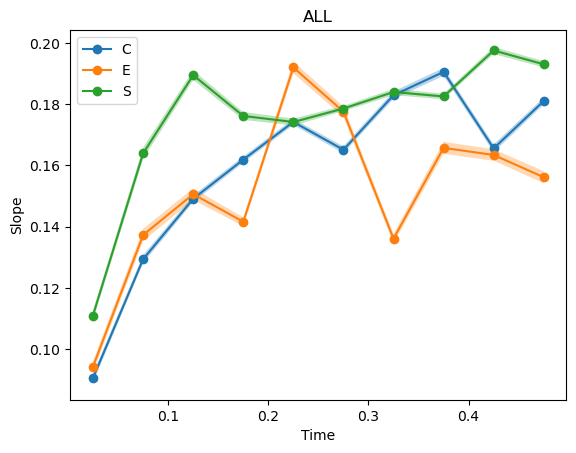

In [ ]:

nbins = 10

bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=nbins)  # Adjust the number of bins as needed
diff_time =  0.5/nbins

#all
bins_data_F['Num'] = bins_data_F.groupby(['Session', 'Subject', 'time_rel'])['Slope'].transform('count')
bins_data_F['Freq'] = (bins_data_F['Num'] / diff_time)/(3600*5)
bins_data_F['Group'] = bins_data_F['Subject'].str[0]
mean_data_F = bins_data_F.groupby(['Group','time_rel'])['Freq'].agg(['mean', 'sem']).reset_index()


# Plot the individual curves for each name
mean_data_F["time_rel_c"] = mean_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = mean_data_F['time_rel_c'].unique()


#ALL
plt.title('ALL')
for name, group in mean_data_F.groupby('Group'):
    plt.plot(time_intervals, group['mean'], marker='o', label=name)
    plt.fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Slope')
plt.legend()
plt.show()



In [ ]:
bdf_fc

Id  time_rel_c      Freq    Age    sAge
0    C06_1     0.02475  0.044444  14.20  0.2840
1    C06_1     0.07500  0.116667  14.20  0.2840
2    C06_1     0.12500  0.141111  14.20  0.2840
3    C06_1     0.17500  0.147778  14.20  0.2840
4    C06_1     0.22500  0.214444  14.20  0.2840
..     ...         ...       ...    ...     ...
135  C38_1     0.27500  0.156667  19.38  0.3876
136  C38_1     0.32500  0.131111  19.38  0.3876
137  C38_1     0.37500  0.136667  19.38  0.3876
138  C38_1     0.42500  0.140000  19.38  0.3876
139  C38_1     0.47500  0.193333  19.38  0.3876

[140 rows x 5 columns]

[0.00000000e+00 8.33333333e-06 6.85833333e-03 6.85833333e-03
 6.85833333e-03 6.85833333e-03 1.15194444e-02 1.70416667e-02
 1.92000000e-02 1.92111111e-02 1.92111111e-02 2.21055556e-02
 2.21111111e-02 2.21250000e-02 2.41361111e-02 2.41416667e-02
 2.41444444e-02 2.41500000e-02 2.46805556e-02 2.46888889e-02
 2.46944444e-02 2.46944444e-02 2.90694444e-02 3.31611111e-02
 3.98888889e-02 3.98944444e-02 4.04583333e-02 4.12944444e-02
 4.12944444e-02 4.12972222e-02 4.13000000e-02 4.20500000e-02
 4.20583333e-02 4.20583333e-02 4.70777778e-02 4.70944444e-02
 4.71027778e-02 4.86194444e-02 4.90194444e-02 4.90277778e-02
 5.06277778e-02 5.06333333e-02 5.06722222e-02 5.11083333e-02
 5.16944444e-02 5.21500000e-02 5.36333333e-02 5.50555556e-02
 5.50583333e-02 5.50611111e-02 5.54194444e-02 5.54222222e-02
 5.54222222e-02 5.61111111e-02 5.61138889e-02 5.61222222e-02
 5.79888889e-02 5.79888889e-02 5.83972222e-02 5.83972222e-02
 5.84055556e-02 5.84083333e-02 5.84166667e-02 5.87694444e-02
 5.87722222e-02 5.936666

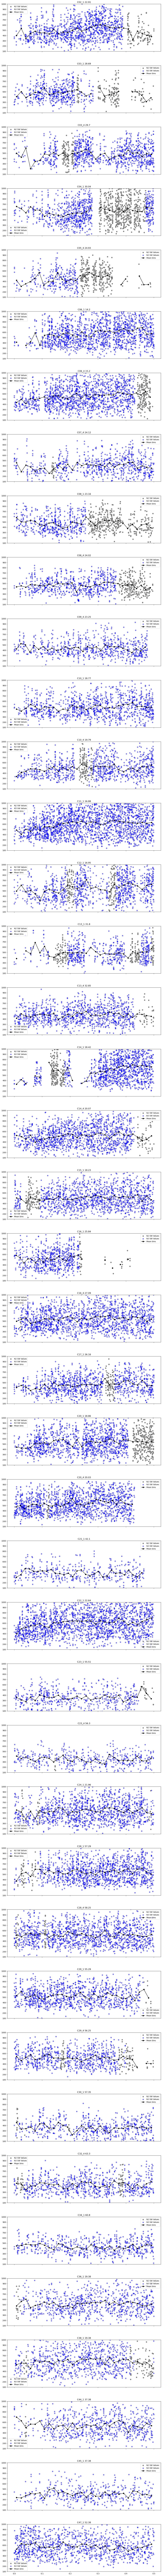

In [ ]:
#LOG NO BINS
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50

def func(x, a, b, c):
    return a - (b * np.exp(-x/c))

def func_l(x, m,n):
    return m + n*x


x_list = []
a_list = []
b_list = []
c_list = []

m_list = []
n_list = []

# Get the number of subplots needed
num_subplots = len(daf_c['Id'].unique())

# Create a figure and subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 6*num_subplots),sharex=True, gridspec_kw={'hspace': 0.3})

for idx, (name, Subject) in enumerate(daf_c.groupby('Id')):

    x = Subject.time_rel.values
    x = x[:int(len(x)*0.70)]
    y = Subject.Slope.values
    y = y[:int(len(y)*0.70)] 

    if name == 'C02_1':
        print(x)
        print(y)

    popt, pcov = curve_fit(func, x, y, bounds=([0, -1000, 0], [1000, 1000, 5]))

    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

    poptl, pcovl = curve_fit(func_l, x, y, bounds=([0, -1000], [1000, 1000]))

    coef_m = popt[0]
    coef_n = popt[1]


    m_list.append(coef_m)
    n_list.append(coef_n)



    # Plot on the respective subplot
    x_time = np.arange(0,0.5,0.01)
    Subject_2 = Subject[Subject['Stage']==2]
    Subject_3 = Subject[Subject['Stage']==3]
    axs[idx].scatter(Subject_2.time_rel.values, Subject_2.Slope.values,c='gray',label='N2 SW Values')
    axs[idx].scatter(Subject_3.time_rel.values, Subject_3.Slope.values,c='blue',label='N3 SW Values', alpha=0.5)
    axs[idx].set_title(name + ' ' + str(Subject['Age'].unique()[0]))
    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=30)
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid)
    time_intervals = bins_Subject['time_rel_c'].unique()
    axs[idx].plot(time_intervals, bins_Subject['Slope'], marker='o', c = 'black', label='Mean bins')
    axs[idx].set_ylim([100,1000])
    axs[idx].legend()


plt.show()
        


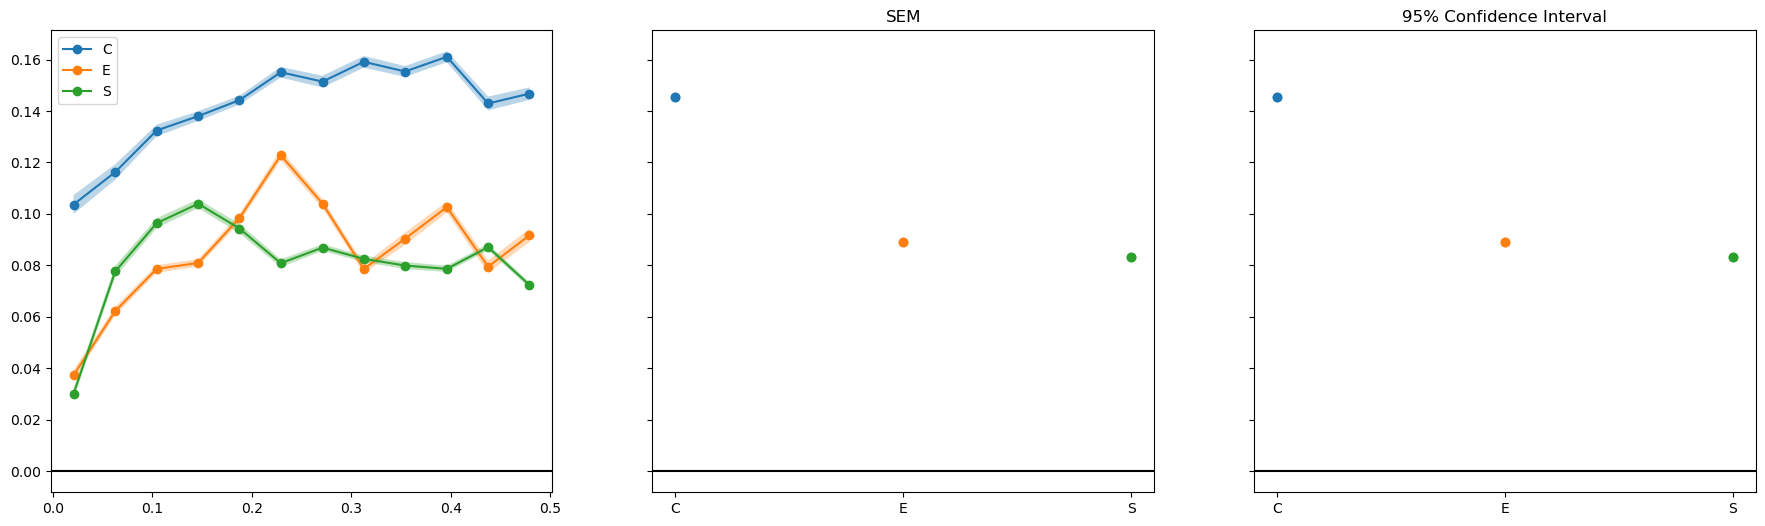

In [ ]:
nbins = 12
bdf = data_allF.copy()
bdf = bdf[bdf['Session']==1]
bdf['time_rel'] = pd.cut(bdf['time_rel'], bins=nbins)  # Adjust the number of bins as needed
diff_time =  0.5/nbins

#all
bdf['Num'] = bdf.groupby(['Session', 'Subject', 'time_rel'])['Slope'].transform('count')
bdf['Freq'] = (bdf['Num'] / diff_time)/(3600*5)
bdf['Group'] = bdf['Subject'].str[0]
bdf= bdf.merge(age)

bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)


bdf['Freq_n'] = (
    total_coefs[0] +
    total_coefs[1] * bdf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-bdf['Age'] / total_coefs[4])) * bdf['time_rel_c'].astype(float)
)

bdf['Freq_rel'] = bdf['Freq'] - bdf['Freq_n']

bdf['Freq_rel'] = pd.to_numeric(bdf['Freq_rel'], errors='coerce')

mdf = bdf.groupby(['Group', 'time_rel'])['Freq_rel'].agg(['mean', 'sem']).reset_index()
mdf_t = bdf.groupby(['Group'])['Freq_rel'].agg(['mean', 'sem']).reset_index()

mdf["time_rel_c"] = mdf["time_rel"].apply(lambda x: x.mid)
time_intervals = mdf['time_rel_c'].unique()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdf.groupby('Group'):
    if name == 'C':
        diff_c = group['mean']
    if name == 'E':
        diff_e = group['mean']
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


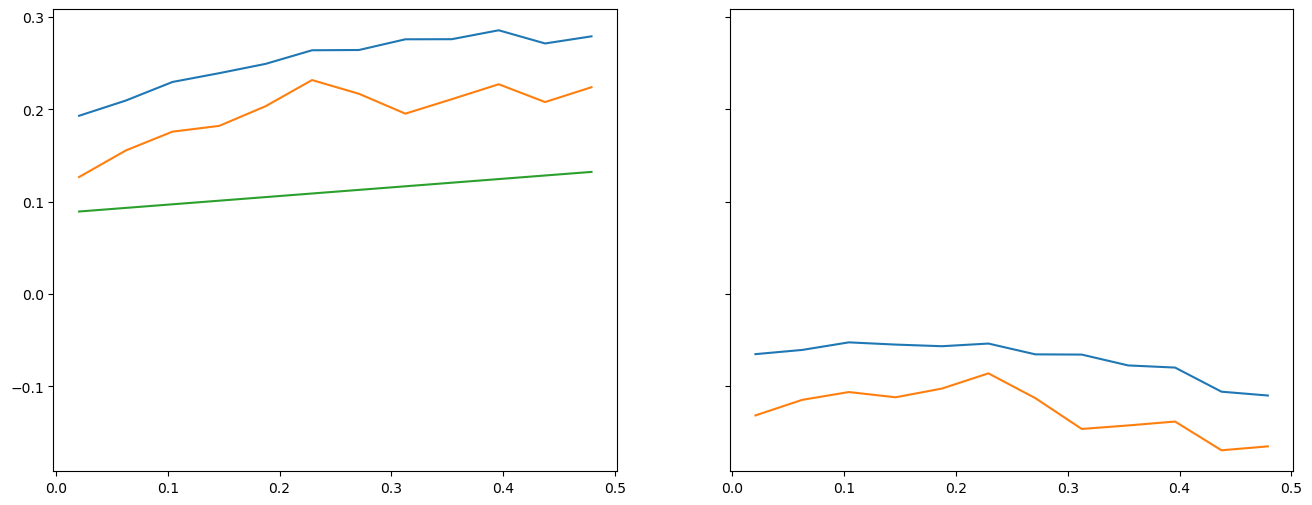

In [ ]:
age_y = 18
age_o = 55
time_intervals

Freq_pred_y = total_coefs[0] + total_coefs[1] * age_y + (total_coefs[2] - total_coefs[3] * np.exp(-age_y/ total_coefs[4])) * time_intervals.astype(float)
Freq_pred_cy = Freq_pred_y + diff_c
Freq_pred_ey = Freq_pred_y + diff_e

Freq_pred_o = total_coefs[0] + total_coefs[1] * age_o + (total_coefs[2] - total_coefs[3] * np.exp(-age_o/ total_coefs[4])) * time_intervals.astype(float)
Freq_pred_co = Freq_pred_o + diff_c
Freq_pred_eo = Freq_pred_o + diff_e

fig, ax = plt.subplots(1, 2, figsize = (16, 6),sharey=True)


ax[0].plot(time_intervals, Freq_pred_cy)
ax[0].plot(time_intervals, Freq_pred_ey)
ax[0].plot(time_intervals, Freq_pred_y)
ax[1].plot(time_intervals, Freq_pred_co)
ax[1].plot(time_intervals, Freq_pred_eo)



In [ ]:
model = Lmer('Slope_rel ~ time_rel_c*Age*Group + (1|Subject)', data=bdf)
model.fit()



print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "time_rel". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Birthdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while 

RRuntimeError: Error in eval(predvars, data, env) : object 'Slope_rel' not found


In [ ]:
# DATA

# x is a matrix one column per participant, one row per time  70 * 8
# age is a vector of 70 * 1 values
# group is a matrix of one column per participant, 70 * 3 rows (is_control, is_enc, is_sq)

# X is a matrix with all data above:  70 * 12(8+1+3) 

# PARAMETERS
# mi is a vector of 70 values
# mage is a scalar
# mgroup is a vector of 3 values (control, enc, sq)


# Y = 8*70



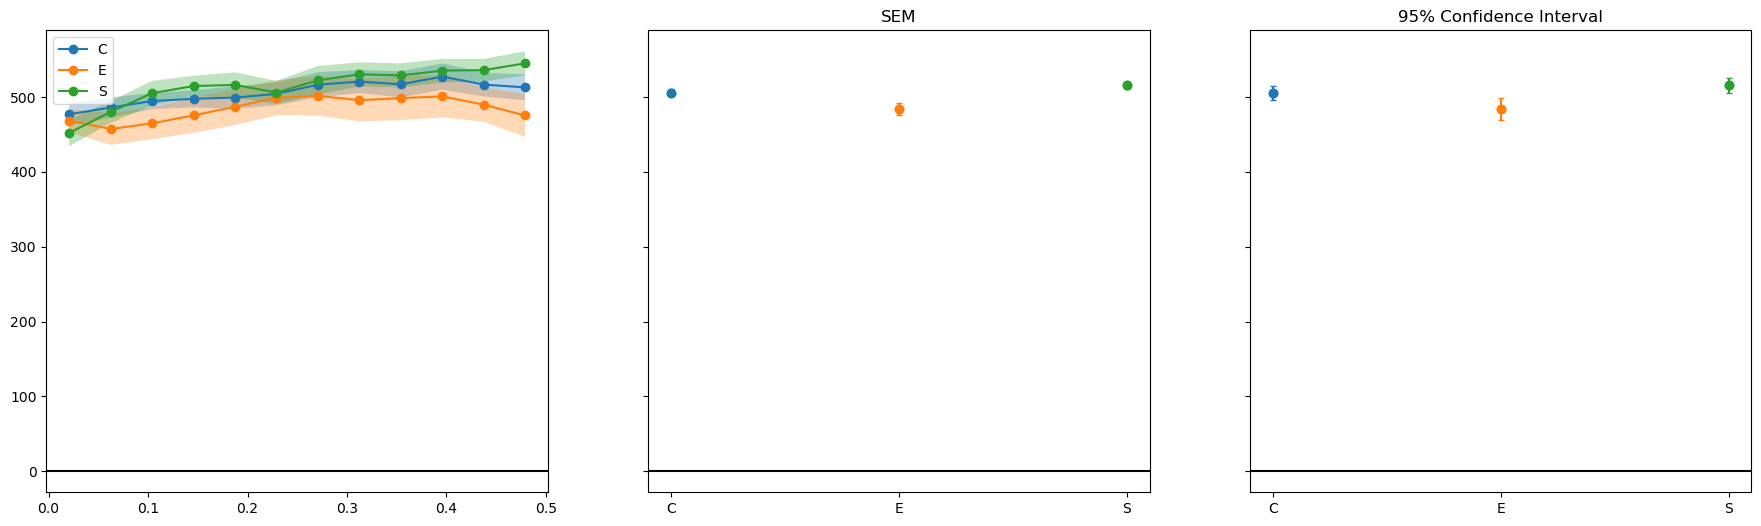

In [ ]:
daf = data_allF.copy()
daf = daf[daf['Session']==1]
daf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * daf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-daf['Age'] / total_coefs[4])) * daf['time_rel']
)

daf['Slope_rel'] = daf['Slope'] - daf['Slope_n']
bdaf = daf.copy()
bdaf['time_rel'] = pd.cut(bdaf['time_rel'], bins=12)  
bdaf = bdaf.groupby(['Session','Subject','time_rel'])['Slope_rel'].mean().reset_index()
bdaf['Group'] = bdaf['Subject'].str[0]
bdaf["time_rel_c"] = bdaf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdaf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdaf = bdaf.merge(age)

bdaf['Age'] = pd.to_numeric(bdaf['Age'], errors='coerce')
bdaf['time_rel_c'] = pd.to_numeric(bdaf['time_rel_c'], errors='coerce')

mdaf = bdaf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdaf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [ ]:
mdaf.head()


Group           time_rel        mean        sem
0     C  (-0.0005, 0.0417]  476.902246  14.881828
1     C   (0.0417, 0.0833]  485.946532  13.448175
2     C    (0.0833, 0.125]  494.566212  10.784860
3     C     (0.125, 0.167]  497.573879  11.394233
4     C     (0.167, 0.208]  499.182454  15.112567

In [ ]:
mdf.head()


Group         time_rel        mean        sem
0     C  (-0.0005, 0.05]  472.569053  14.445174
1     C      (0.05, 0.1]  490.451183  12.184038
2     C      (0.1, 0.15]  496.989176  10.274982
3     C      (0.15, 0.2]  501.752874  13.879082
4     C      (0.2, 0.25]  502.487921  14.946547

In [ ]:
model = Lmer('Slope_rel ~ time_rel*Age*Group + (1|Subject)', data=daf)
model.fit()


print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 66179	 Groups: {'Subject': 60.0}

Log-likelihood: -441229.287 	 AIC: 882486.574

Random effects:

                 Name        Var      Std
Subject   (Intercept)   4514.396   67.189
Residual               36069.685  189.920

No random effect correlations specified

Fixed effects:

                       Estimate      2.5_ci     97.5_ci         SE  \
(Intercept)          509.486587  451.351239  567.621934  29.661437   
time_rel             302.070460  265.649564  338.491356  18.582431   
Age                   -0.890392   -2.587281    0.806497   0.865776   
GroupE                44.671638  -67.792066  157.135343  57.380496   
GroupS                42.778406 -115.909882  201.466694  80.964900   
time_rel:Age          -5.937904   -7.070977   -4.804831   0.578109   
time_rel:GroupE       -4.403752  -79.140950   70.333445  38.131924   

In [ ]:
bdf.head()



Session Subject         time_rel       Slope Group  time_rel_c  \
0        1     C02  (-0.0005, 0.05]  435.705456     C     0.02475   
1        1     C02      (0.05, 0.1]  457.229482     C     0.07500   
2        1     C02      (0.1, 0.15]  471.398797     C     0.12500   
3        1     C02      (0.15, 0.2]  456.458012     C     0.17500   
4        1     C02      (0.2, 0.25]  510.360134     C     0.22500   

             Birthdate             Testdate M/F    Age   Slope_n   Slope_rel  
0  1994-05-28 00:00:00  2017-04-26 00:00:00   F  22.91  0.138912  435.566544  
1  1994-05-28 00:00:00  2017-04-26 00:00:00   F  22.91  0.146627  457.082855  
2  1994-05-28 00:00:00  2017-04-26 00:00:00   F  22.91  0.154304  471.244493  
3  1994-05-28 00:00:00  2017-04-26 00:00:00   F  22.91  0.161981  456.296031  
4  1994-05-28 00:00:00  2017-04-26 00:00:00   F  22.91  0.169658  510.190475

 _____________ Fitted Parameters A:
a: -2948.405002647084
b: -3610.729193787852
c: 999.9999999448635
 _____________ Fitted Parameters B:
a: -105.89005040558592
b: -355.8046342335666
c: 57.492630311743085
 _____________ Fitted Parameters C:
a: 2.1655929925023876
b: -1.5831674967469109e-12
c: 999.999998056755


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Slope analysis')

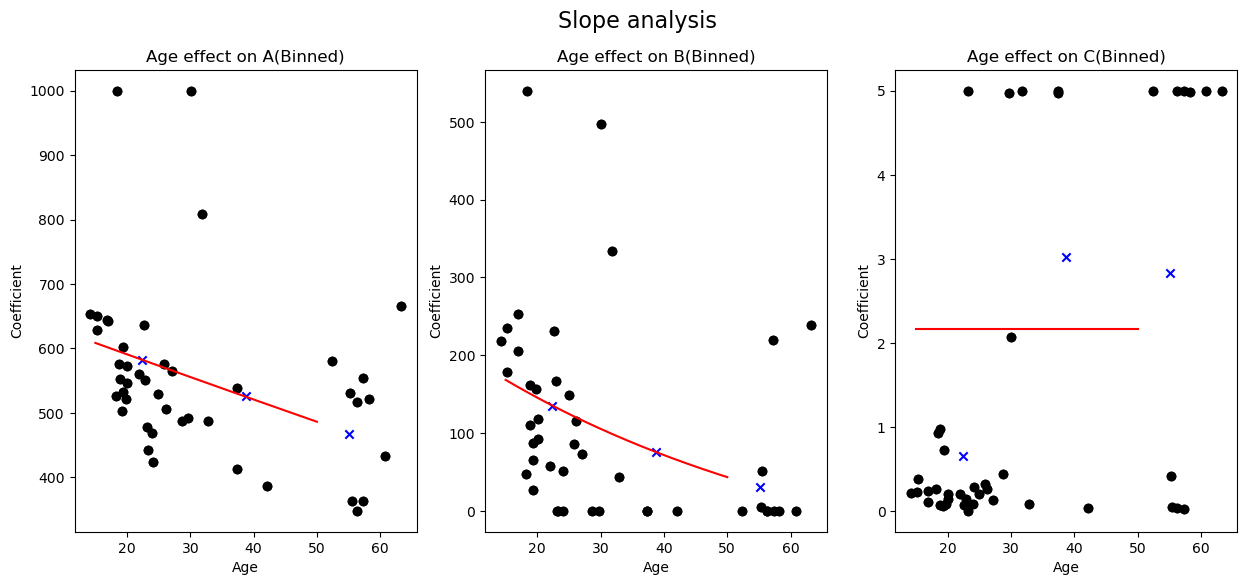

In [ ]:

#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c)) 




x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]
    

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)
   

fig, ax = plt.subplots(1, 3, figsize = (15, 6))


splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 3
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])
    


    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=16)



/tmp/ipykernel_1204361/3904100052.py:66: RuntimeWarning: Mean of empty slice.
  bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: array must not contain infs or NaNs

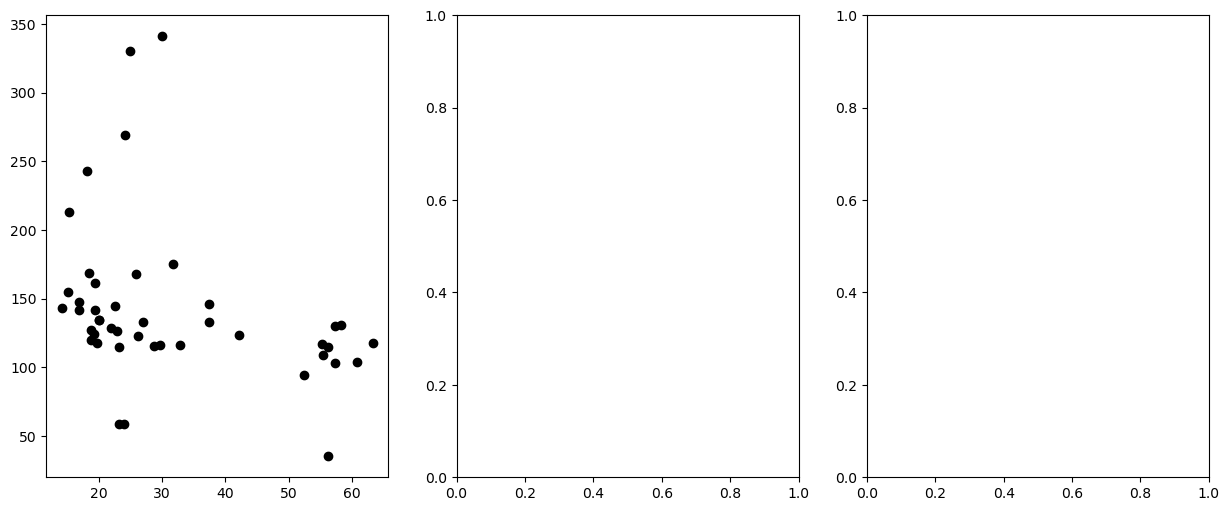

In [ ]:
#LOG NO BINS AMPLITUDE


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.PTP.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,-1000,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)


 _____________ Fitted Parameters A:
a: 280.03757987570435
b: -554.3078475202093
c: 9.938707920733846
 _____________ Fitted Parameters B:
a: 291.98730308106235
b: -635.1800236914736
c: 8.154294074888437
 _____________ Fitted Parameters C:
a: -5.39034680507294
b: -5.7845324702553915
c: 999.9999999967915


Text(0.5, 0.98, 'Amplitude analysis')

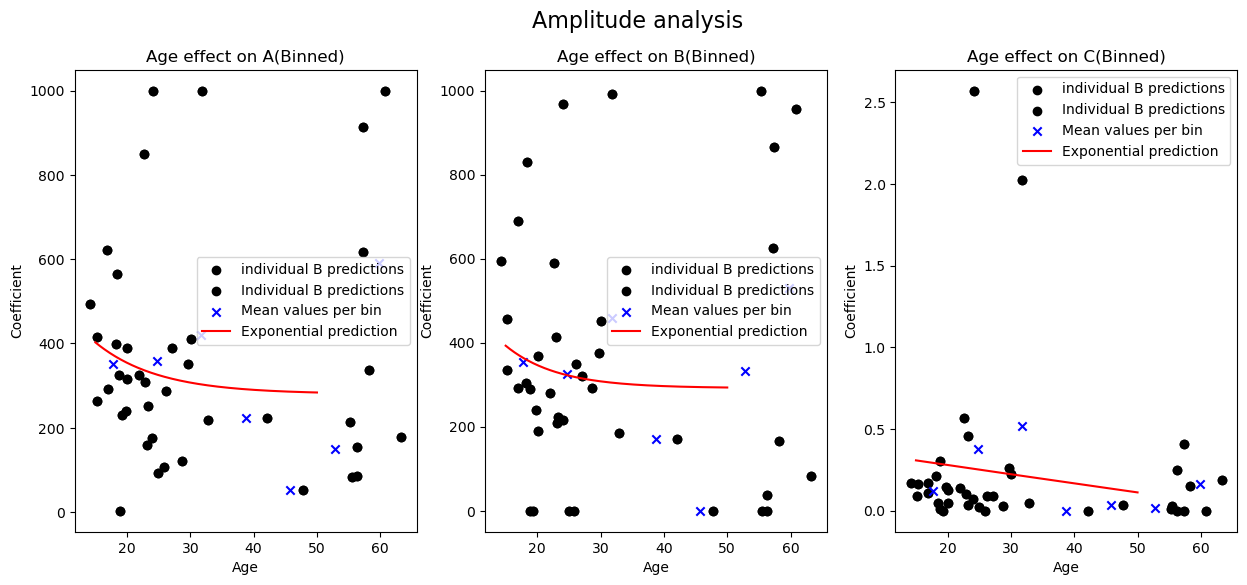

In [ ]:
#LOG NO BINS NUMBER


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)

    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=8)  # Adjust the number of bins as needed
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].count().reset_index()
    bdf_c['Group'] = bdf_c['Subject'].str[0]
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid).astype('object')
    times_Subject = bins_Subject['time_rel_c'].unique()
    
    x = bins_Subject.time_rel_c.values
    y = bins_Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    if popt[2] > 4:
        popt[2] = 0

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)

NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN


[]

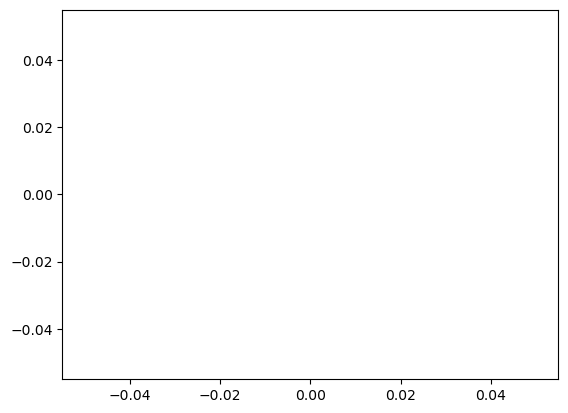

In [ ]:
#LOG WITH BINS




#CONTROL SWA found

bdf_c = bdf_c

bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
bdf_c['sAge'] = bdf_c['Age']/50


def func(x, a, b, c):

    return a  + (b * np.exp(-x/c))


for name, Subject in bdf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel_c.values
    y = Subject.Slope.values
    
    try:
        popt, pcov = curve_fit(func, x, y)
    

        #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
        coef = popt[1]
        #age = Subject['sAge'].unique()[0]
        plt.scatter(age,coef, color='black')

    except:
        print('NAN')

    #print(Subject['sAge'].unique()[0])
    #print(coef)
   
    
    
plt.plot()

C34_1
[0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475
 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475
 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475
 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475
 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475 0.02475
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.07500000000000001 0.07500000000000001 0.07500000000000001
 0.0750000000000000

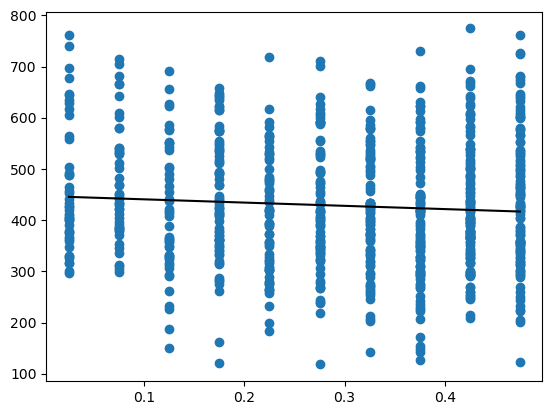

In [ ]:
print(name)
plt.scatter(Subject.time_rel_c,Subject.Slope.values)
print(x)
print(popt[0])
print(popt[1])
print(popt[2])
x = Subject.time_rel_c.values.astype(float)
plt.plot(x, func(x,popt[0],popt[1],popt[2]), color='black')

## SQRT PRED PLOT

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]

daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ sqrt_t', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ sqrt_t * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ sqrt_t * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()





IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## LINE PRED PLOT

/tmp/ipykernel_2747101/2835078309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2835078309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50
/tmp/ipykernel_2747101/2835078309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2047	 R^2: 0.001	 R^2_adj: 0.000

Log-likelihood: -13446.054 	 AIC: 26896.108	 BIC: 26907.356

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 902	 R^2: 0.003	 R^2_adj: 0.001

Log-likelihood: -5807.964 	 AIC: 11619.929	 BIC: 11629.538

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 466	 R^2: 0.003	 R^2_adj: 0.000

Log-likelihood: -2972.719 	 AIC: 5949.438	 BIC: 5957.726

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2500	 R^2: 0.002	 R^2_adj: 0.001

Log-likelihood: -16762.757 	 AIC: 33529.515	 BI

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1130	 R^2: 0.000	 R^2_adj: -0.001

Log-likelihood: -7311.558 	 AIC: 14627.116	 BIC: 14637.176

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1701	 R^2: 0.001	 R^2_adj: 0.001

Log-likelihood: -10866.761 	 AIC: 21737.521	 BIC: 21748.399

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 4434	 R^2: 0.024	 R^2_adj: 0.024

Log-likelihood: -29964.563 	 AIC: 59933.127	 BIC: 59945.921

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2443	 R^2: 0.000	 R^2_adj: -0.000

Log-likelihood: -15994.865 	 AIC: 31993.

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:25: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel*(sAge)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.056	 R^2_adj: 0.056

Log-likelihood: -471102.749 	 AIC: 942213.498	 BIC: 942250.174

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.059	 R^2_adj: 0.059

Log-likelihood: -471007.692 	 AIC: 942027.384	 BIC: 942082.397

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2+sAge3)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.061	 R^2_adj: 0.061

Log-likelihood: -470926.638 	 AIC: 941869.275	 BIC: 941942.626

Fixed effects:



/tmp/ipykernel_2747101/2835078309.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(sAge_values, model3.coefs['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][5]*sAge_values
/tmp/ipykernel_2747101/2835078309.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][6]*sAge_values2
/tmp/ipykernel_2747101/2835078309.py:45:

Formula: Slope~time_rel*(sAge+sAge2+sAge3+sAge4)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.062	 R^2_adj: 0.062

Log-likelihood: -470896.791 	 AIC: 941813.582	 BIC: 941905.270

Fixed effects:



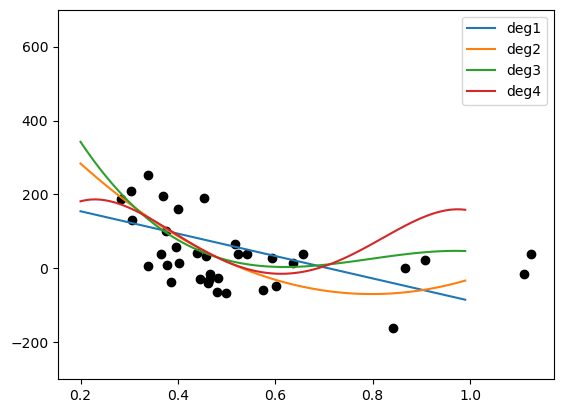

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ time_rel', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ time_rel * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ time_rel * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()


## LOG PRED PLOT

/tmp/ipykernel_2747101/38719194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/38719194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


36
36
36


[]

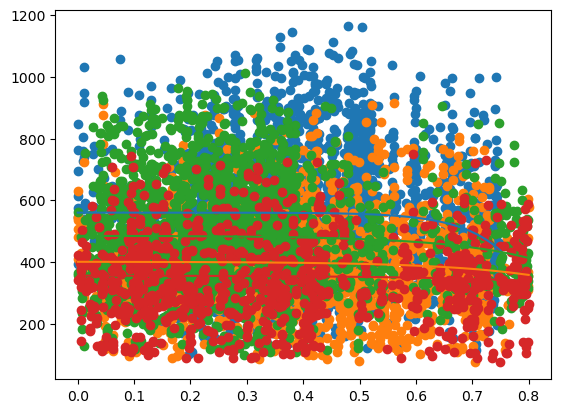

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50




def func(x, a, b, c):
    return a  + (b * np.exp(-x/c))

c = 0
f = 0
g = 0

for name, Subject in daf_c.groupby('Id'):
    c = c +1

    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values

      
    popt, pcov = curve_fit(func, x, y)
    g = g + 1
    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef = 1/popt[1]
    #age = Subject['sAge'].unique()[0]
    #plt.scatter(age,coef, color='black')

    f = f + 1
    #print(Subject['sAge'].unique()[0])
    #print(coef)

    if coef < -1:
        plt.scatter(Subject.time_rel.values,Subject.Slope.values)
        plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    
    
print(c)
print(f)
print(g)
    
plt.plot()

# NO BINS MODEL

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c.head()

/tmp/ipykernel_2747101/2859326843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2859326843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


index   Wave     Start  NegPeak  MidCrossing  PosPeak      End  \
47  2831880  12769  0.673000  2423.08      2423.34  2423.57  2423.91   
48  2830582  11471  0.679381  2446.06      2446.33  2446.52  2447.30   
49  2833475  14364  0.679381  2446.04      2446.28  2446.48  2446.75   
50  2835266  16155  0.679381  2446.03      2446.27  2446.47  2446.75   
51  2836802  17691  0.679381  2446.02      2446.25  2446.47  2446.79   

    Duration  ValNegPeak  ValPosPeak         PTP       Slope  Frequency  \
47      1.11  -46.707747   32.177395   78.885141  303.404390   0.900901   
48      1.53  -89.754462   38.805616  128.560078  476.148436   0.653595   
49      0.98 -117.820316   70.414380  188.234695  784.311231   1.020408   
50      0.98 -111.116778   73.118567  184.235346  767.647273   1.020408   
51      1.02  -55.017271   42.728858   97.746129  424.983169   0.980392   

    Stage Channel  IdxChannel Group Subject Session    Age Machine  \
47      3      F3           7     C     C02       1  22.91       O   
48      3      F7           6     C     C02       1  22.91       O   
49      3      Fz           8     C     C02       1  22.91       O   
50      3      F4           9     C     C02       1  22.91       O   
51      3      F8          10     C     C02       1  22.91       O   

   ConfArousal Position  N3_times  time_rel     Id    sAge  
47           0        F     0.673  0.000000  C02_1  0.4582  
48           0        F     0.673  0.006381  C02_1  0.4582  
49           0        F     0.673  0.006381  C02_1  0.4582  
50           0        F     0.673  0.006381  C02_1  0.4582  
51           0        F     0.673  0.006381  C02_1  0.4582

(array([7629., 2848., 7436., 3114., 9113., 7836.,    0., 3870., 9012.,
        2762.,  492., 3834., 3674.,  902.,  466., 2500., 1130., 1701.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   88.,
         419.,    0.,  256.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1803.]),
 array([0.284  , 0.30505, 0.3261 , 0.34715, 0.3682 , 0.38925, 0.4103 ,
        0.43135, 0.4524 , 0.47345, 0.4945 , 0.51555, 0.5366 , 0.55765,
        0.5787 , 0.59975, 0.6208 , 0.64185, 0.6629 , 0.68395, 0.705  ,
        0.72605, 0.7471 , 0.76815, 0.7892 , 0.81025, 0.8313 , 0.85235,
        0.8734 , 0.89445, 0.9155 , 0.93655, 0.9576 , 0.97865, 0.9997 ,
        1.02075, 1.0418 , 1.06285, 1.0839 , 1.10495, 1.126  ]),
 <BarContainer object of 40 artists>)

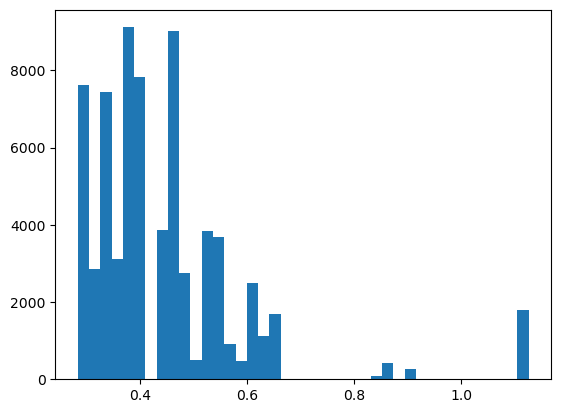

In [ ]:
plt.hist(daf_c['sAge'],40)

# UP TO deg 5

In [ ]:


model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2) + I(sAge^3) + I(sAge^4) + I(sAge^5)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2)+I(sAge^3)+I(sAge^4)+I(sAge^5))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 70885	 Groups: {'Subject:Session': 36.0}

Log-likelihood: -468538.719 	 AIC: 937105.439

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   2783.254   52.757
Residual                      32268.013  179.633

No random effect correlations specified

Fixed effects:

                        Estimate         2.5_ci        97.5_ci             SE  \
(Intercept)           545.230148   -4205.704435    5296.164730    2423.990757   
time_rel              650.151609   -1359.763086    2660.066304    1025.485525   
sAge                 2439.862933  -40785.782097   45665.507963   22054.305779   
I(sAge^2)          -18231.543279 -168347.025651  131883.939093   76590.939199   
I(sAge^3)           44263.778946 -204135.601478  292663.159371  126736.706585   
I(s

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-182.42663567,   -9.98758106,  298.17521341, ...,   79.22585185,
         53.6560655 ,  190.42256289])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

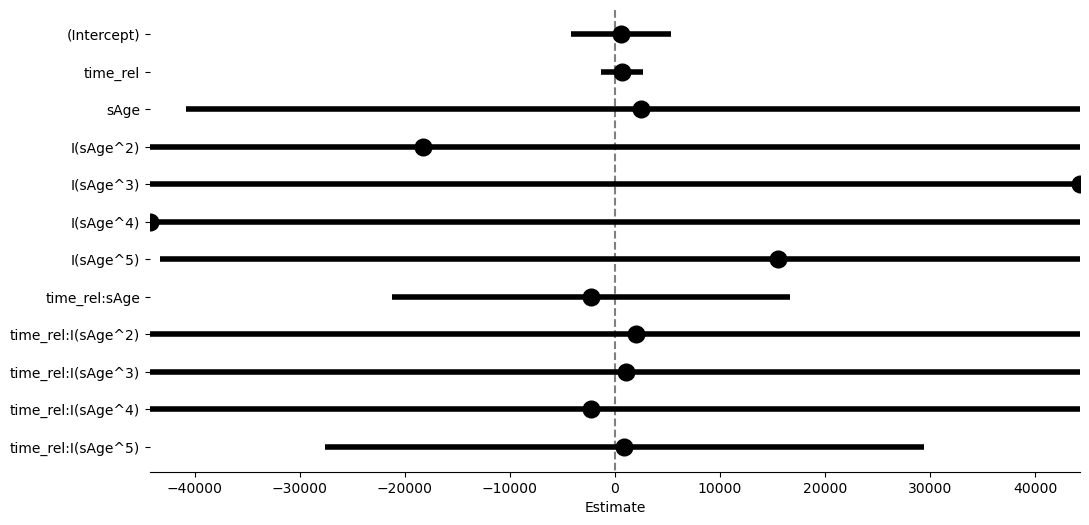

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)

    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


ValueError: Length of values (70885) does not match length of index (15362)

<Figure size 1000x600 with 0 Axes>

# Up to 2 deg BOTH

In [ ]:
model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2)) + I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2))+I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102381.231 	 AIC: 204784.462

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3953.781   62.879
Residual                      36005.746  189.752

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   305.326359  -195.244724   805.897442   
time_rel                      -28.407445 -1186.611038  1129.796147   
sAge                           82.758625 -1890.453768  2055.971018   
I(sAge^2)                     148.229150 -1690.067729  1986.526028   
I(sqrt(time_rel))             813.992976  -606.018835  2234.004788   
time_rel:sAge                -603.437313 -5307.231487  4100.3568

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-247.15359379,  -48.63753464,   16.24605027, ...,  338.3323455 ,
        -76.30385387, -163.44301389])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

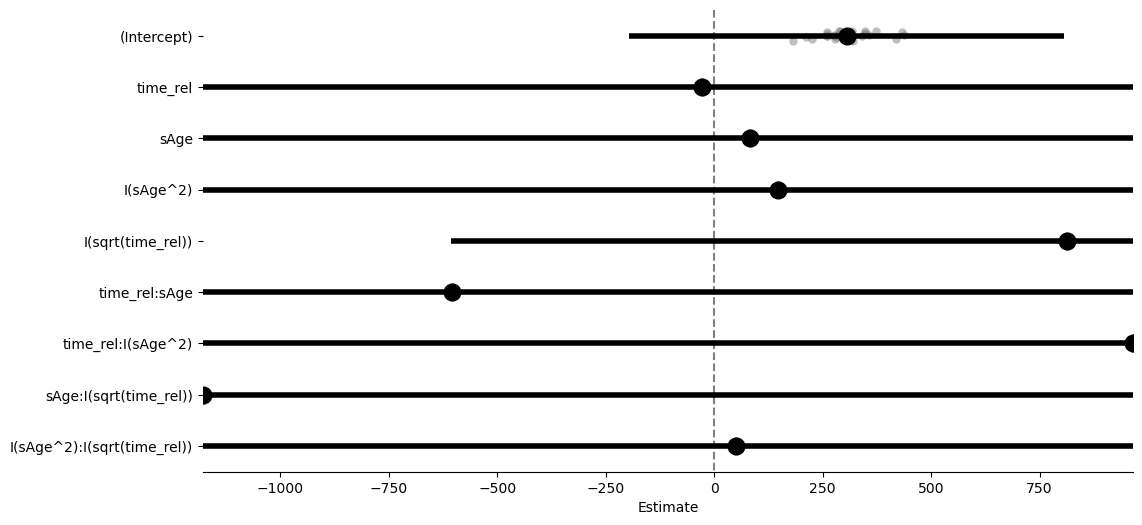

In [ ]:
model_sq.plot_summary()

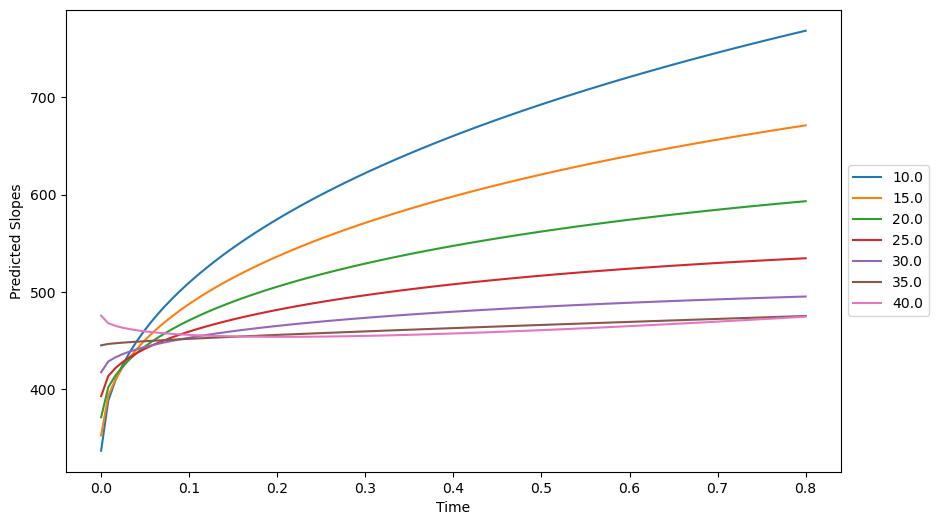

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


# SQRT 5 Deg BOTH

In [ ]:


model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2) +  I(sAge^3)) + time_rel * (sAge + I(sAge^2) + I(sAge^3)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2)+I(sAge^3))+time_rel*(sAge+I(sAge^2)+I(sAge^3))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102349.974 	 AIC: 204727.949

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3606.192   60.052
Residual                      36006.367  189.753

No random effect correlations specified

Fixed effects:

                                 Estimate        2.5_ci        97.5_ci  \
(Intercept)                     36.922543  -1799.604734    1873.449820   
I(sqrt(time_rel))             4522.657768   -701.952485    9747.268022   
sAge                          1904.851570  -9224.171641   13033.874781   
I(sAge^2)                    -3669.305727 -24993.713699   17655.102246   
I(sAge^3)                     2442.506488 -10357.671495   15242.684472   
time_rel            

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-258.63390099,  -57.65674197,   10.43682056, ...,  336.66618106,
        -77.97283668, -165.11606538])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

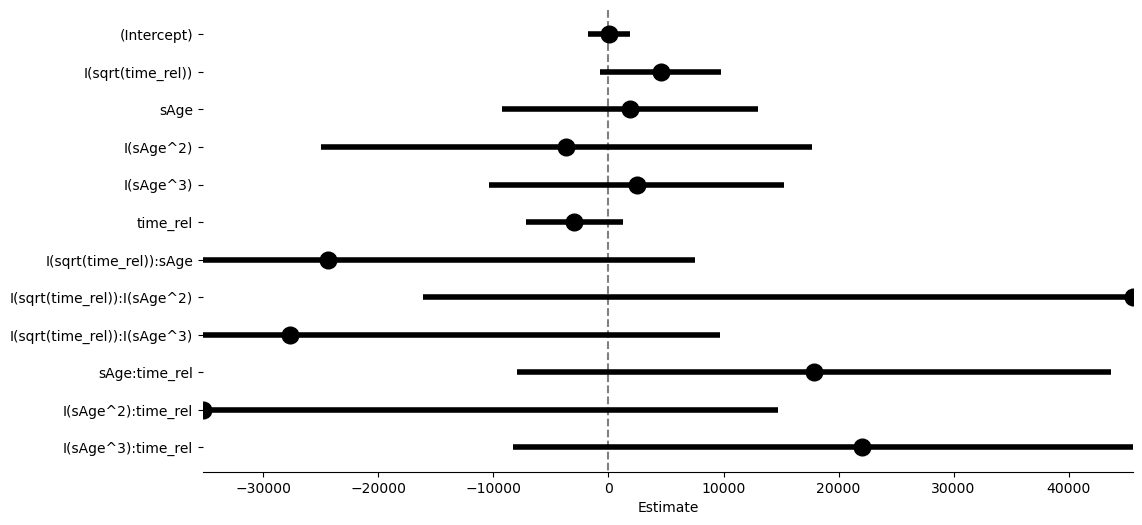

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    

ValueError: operands could not be broadcast together with shapes (15362,) (123921,) 

<Figure size 1000x600 with 0 Axes>

# SQRT deg 2

In [ ]:
model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals

Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 123921	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -818610.531 	 AIC: 1637237.061

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   4269.829   65.344
Residual                      31984.732  178.843

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   332.977855    58.379422   607.576289   
I(sqrt(time_rel))             644.881553   550.828292   738.934814   
sAge                           69.927264  -975.555671  1115.410200   
I(sAge^2)                     -11.091886  -945.498875   923.315104   
I(sqrt(time_rel)):sAge      -1453.831688 -1854.669336 -1052.994040   
I(sqrt(time_rel)):I(sAge^2)   913.942258   505.618396  1322.266121   

                 

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([  96.03910818,  119.93726911, -146.7354911 , ..., -129.03346606,
       -166.11564097, -278.91066559])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

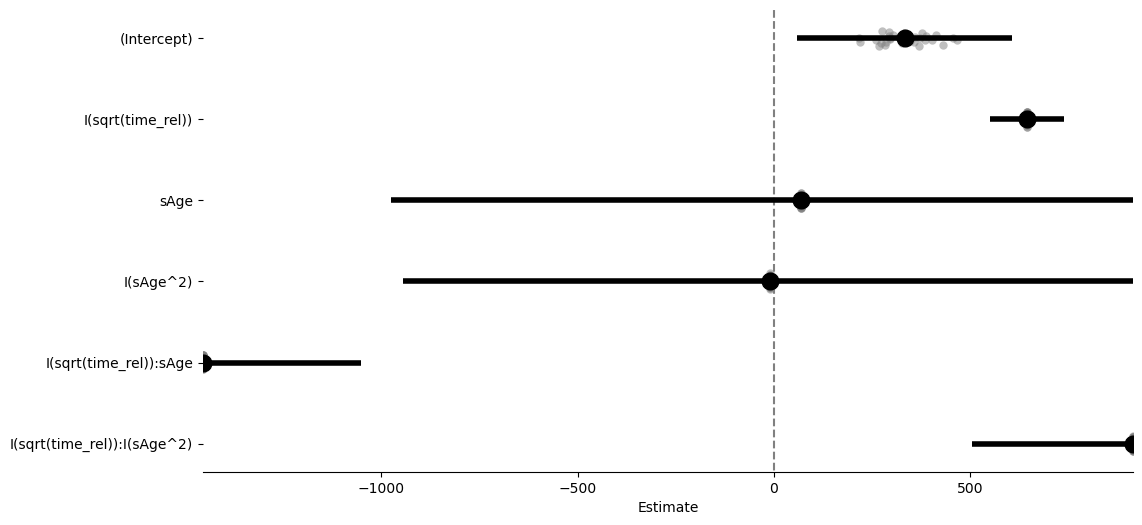

In [ ]:
model_sq.plot_summary()

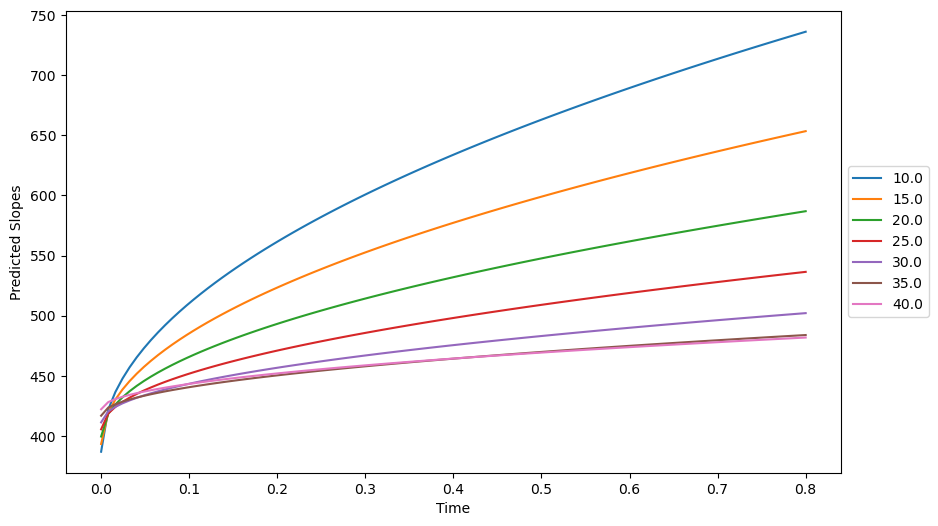

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   